In [4]:
import random
from datetime import datetime
import os

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, utils, optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm.notebook import tqdm

Ссылка на датасет - https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

Задача: Даны новости. Обучить модель, которая должна определить реальная новость или выдуманная.

In [8]:
RANDOM_STATE = 17
torch.manual_seed(RANDOM_STATE)
random.seed = RANDOM_STATE

In [5]:
true_data_path = os.path.join('data', 'True.csv')
true_data = pd.read_csv(true_data_path)
true_data['target'] = True
true_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [6]:
fake_data_path = os.path.join('data', 'Fake.csv')
fake_data = pd.read_csv(fake_data_path)
fake_data['target'] = False
fake_data.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",False
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",False
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",False
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",False
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",False


In [7]:
data = pd.concat([true_data, fake_data], ignore_index=True)
data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
data.head()

,title,text,subject,date,target
0,"Reeking Of Desperation, Trump Sends Out ‘Poll...","Facing corruption scandals, nepotism scandals,...",News,"March 23, 2017",False
1,Trump dictated misleading statement on son's m...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"August 1, 2017",True
2,Former soccer star Kaladze runs for mayor in G...,TBILISI (Reuters) - Kakha Kaladze climbed to t...,worldnews,"October 19, 2017",True
3,Puerto Rico governor ups revenue forecast in r...,(Reuters) - Puerto Rico’s governor said on Sat...,politicsNews,"March 11, 2017",True
4,Trump Put An American Flag On His Birthday Tw...,It seems that Donald Trump is often incapable ...,News,"April 27, 2017",False


### Preprocessing 

In [52]:
TEXT_COLUMNS = ['title', 'text']

- Пробразование даты в `timestamp`

In [53]:
def date_to_timestamp(date):
    formats = ["%B %d, %Y", "%b %d, %Y", "%d-%b-%y"]
    for date_format in formats:
        try:
            return datetime.strptime(date.strip(), date_format).timestamp()
        except:
            pass
    print(date)
    return 0

In [54]:
print('BAD DATES')    
data['date'] = data['date'].apply(date_to_timestamp)
data.head()

BAD DATES
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/


,title,text,subject,date,target
0,"Reeking Of Desperation, Trump Sends Out ‘Poll...","Facing corruption scandals, nepotism scandals,...",News,1.490227e+09,False
1,Trump dictated misleading statement on son's m...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,1.501546e+09,True
2,Former soccer star Kaladze runs for mayor in G...,TBILISI (Reuters) - Kakha Kaladze climbed to t...,worldnews,1.508371e+09,True
3,Puerto Rico governor ups revenue forecast in r...,(Reuters) - Puerto Rico’s governor said on Sat...,politicsNews,1.489190e+09,True
4,Trump Put An American Flag On His Birthday Tw...,It seems that Donald Trump is often incapable ...,News,1.493251e+09,False


- Применение one-hot encoding для категориальных данных

In [55]:
data.subject.unique()

array(['News', 'politicsNews', 'worldnews', 'politics', 'Government News',
       'left-news', 'Middle-east', 'US_News'], dtype=object)

In [56]:
subjects_columns = pd.get_dummies(data.subject)
data[subjects_columns.columns] = subjects_columns
data.drop('subject', inplace=True, axis=1)
data.head()

,title,text,date,target,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews
0,"Reeking Of Desperation, Trump Sends Out ‘Poll...","Facing corruption scandals, nepotism scandals,...",1.490227e+09,False,0,0,1,0,0,0,0,0
1,Trump dictated misleading statement on son's m...,WASHINGTON (Reuters) - U.S. President Donald T...,1.501546e+09,True,0,0,0,0,0,0,1,0
2,Former soccer star Kaladze runs for mayor in G...,TBILISI (Reuters) - Kakha Kaladze climbed to t...,1.508371e+09,True,0,0,0,0,0,0,0,1
3,Puerto Rico governor ups revenue forecast in r...,(Reuters) - Puerto Rico’s governor said on Sat...,1.489190e+09,True,0,0,0,0,0,0,1,0
4,Trump Put An American Flag On His Birthday Tw...,It seems that Donald Trump is often incapable ...,1.493251e+09,False,0,0,1,0,0,0,0,0


- Строим матрицу корреляции:

In [57]:
import seaborn as sns

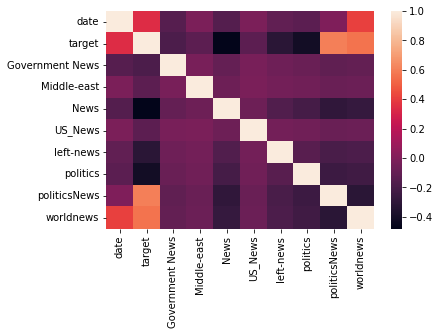

In [58]:
sns.heatmap(data.corr())

Вывод: 
  - Прямая зависимость между `target` и `worldnews`, `politicsNews`(примерно 0.7 в обоих случаях).
  - Обратная зависимость между `target` и `News`(примерно -0.9)
  - Поле `date` при обучении не будет рассмотриваться, потому что коэффициент корреляции низкий(около 0.3).

### Training

In [59]:
BATCH_SIZE = 8
MAX_LEN = 30

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- делим данные на `train` и `test`

In [61]:
data_train, data_test = train_test_split(data, test_size=0.1, random_state=RANDOM_STATE)
print("Train size = ", len(data_train))
print("Test size = ", len(data_test))

Train size =  40408
Test size =  4490


In [62]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return dict(self.data.iloc[idx])

In [63]:
train_dataset = CustomDataset(data_train)
test_dataset = CustomDataset(data_test)

- токенизируем

In [64]:
UNK = "UNK"
PAD = "PAD"

In [65]:
tokenizer = get_tokenizer('basic_english')

In [66]:
def yield_tokens(data: pd.DataFrame):
    for i, row in data.iterrows():
        yield tokenizer(row.text)
        yield tokenizer(row.title)

In [67]:
vocab = build_vocab_from_iterator(yield_tokens(data), specials=[UNK, PAD])
vocab.set_default_index(vocab[UNK])
vocab.set_default_index(vocab[PAD])

Было принято решение: оставить все слова. Из-за того, что нейронка не знает правил расстановки знаков препинания и построения слов в предложении, то по неправильно построенному тексту можно понять, что новость поддельная.

In [68]:
def text_pipeline(text):
    tokens = vocab(tokenizer(text))
    if len(tokens) >= MAX_LEN:
        return tokens[:MAX_LEN]
    return tokens + vocab([PAD] * (MAX_LEN - len(tokens)))

В качестве полей для последующих нейросеток будут взяты `title`и `text`.

In [69]:
def collate_batch(batch):
    processed_batch = []
    text = []
    title = []
    target = []
    for record in batch:
        text.append(text_pipeline(record['text']))
        title.append(text_pipeline(record['title']))
        target.append(int(record['target']))
    result_dict = {
        'text': torch.tensor(text, dtype=torch.int64),
        'title': torch.tensor(title, dtype=torch.int64),
        'target': torch.tensor(target, dtype=torch.int64)
    }
    return result_dict

In [70]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [71]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(loss, accuracy):
  plt.figure(figsize=(16, 5))
  plt.suptitle('Average values loss and accuracy at each epoch')

  epochs = [i+1 for i in range(len(loss))]
  plt.subplot(121)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(epochs, loss)
  
  plt.subplot(122)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(epochs, accuracy)

In [72]:
def test_model(model):
    global test_loader
    global device
    global test_dataset

    correct = 0
    total = len(test_dataset)
    with torch.no_grad():
        for fields_dict in test_loader:
          for field in fields_dict:
            fields_dict[field] = fields_dict[field].to(device)
          outputs = model(**fields_dict)
          _, predicted = torch.max(outputs.data, 1)

          correct += (predicted == fields_dict['target']).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network: {accuracy}')
    return accuracy

In [73]:
def train_model(model, epoch = 1, lr = 0.005):
    global device
    global train_loader
    
    accuracy_values = []
    loss_values = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    total = len(train_loader) * epoch
    progress_bar = iter(tqdm(range(total), total=total, desc="Processing records"))
    for epoch in range(epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, fields_dict in enumerate(train_loader):
            next(progress_bar)
            for field in fields_dict:
              fields_dict[field] = fields_dict[field].to(device)
            optimizer.zero_grad()
            outputs = model(**fields_dict)
            loss = criterion(outputs, fields_dict['target'])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        loss_values.append(average_loss)
        print(f'[{epoch + 1}] loss: {average_loss}')

        average_accuracy = test_model(model)
        accuracy_values.append(average_accuracy)
    torch.cuda.empty_cache()
    try:
        next(progress_bar)
    except StopIteration:
        pass
    print('Finished Training')
    plot_loss_and_accuracy(loss_values, accuracy_values)
    return max(accuracy_values)

In [74]:
network_results = pd.DataFrame(columns=['network', 'accuracy'])

- нейросеть с линейным слоем

In [75]:
embed_dim = 64
vocab_size = len(vocab)

In [76]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.size = MAX_LEN * embed_dim
        self.fc = nn.Linear(self.size * 2, 2)

    def forward(self, text, title, **kwargs):
        text = self.embedding(text)
        title = self.embedding(title)
        with torch.no_grad():
            text = text.view(-1, self.size)
            title = title.view(-1, self.size)
            temp = torch.cat([text, title], 1)
        return self.fc(temp)

Processing records:   0%|          | 0/75765 [00:00<?, ?it/s]

[1] loss: 0.0667170748810827
Accuracy of the network: 99.42093541202672
[2] loss: 0.016153165007744687
Accuracy of the network: 99.64365256124722
[3] loss: 0.00565011033162433
Accuracy of the network: 99.66592427616926
[4] loss: 0.001695558529125023
Accuracy of the network: 99.75501113585746
[5] loss: 0.0009725501186382554
Accuracy of the network: 99.71046770601336
[6] loss: 0.0006945607433558577
Accuracy of the network: 99.71046770601336
[7] loss: 0.00034973950152750703
Accuracy of the network: 99.68819599109132
[8] loss: 4.102049931868841e-05
Accuracy of the network: 99.68819599109132
[9] loss: 1.5204015848969832e-05
Accuracy of the network: 99.71046770601336
[10] loss: 1.1170682724523152e-05
Accuracy of the network: 99.71046770601336
[11] loss: 9.009076824996483e-06
Accuracy of the network: 99.68819599109132
[12] loss: 7.624370069663028e-06
Accuracy of the network: 99.68819599109132
[13] loss: 6.691140149332845e-06
Accuracy of the network: 99.68819599109132
[14] loss: 6.014692220508

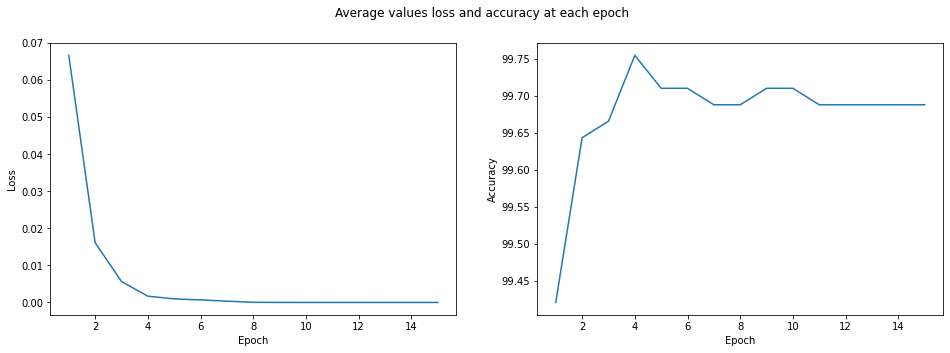

In [77]:
linear_net = LinearNet().to(device)
linear_net_accuracy = train_model(linear_net, epoch=15)

In [78]:
network_results = network_results.append({'network': 'linear_net', 'accuracy': linear_net_accuracy}, ignore_index=True)

__Вывод:__  
  Данная нейросеть показала довольно высокую точность уже после первой эпохи.  
  Нейросеть обучалась 15 эпох, но точность начала падать спустя несколько эпох после начала обучения, хотя показатель потери с каждой эпохой падает. Это значит, что нейросеть начала переобучаться.

- нейросеть со свёрточным слоем

In [79]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.text_sequence = nn.Sequential(
            nn.Conv2d(1, 4, (7, embed_dim)),
            nn.ReLU()
        )
        self.title_sequence = nn.Sequential(
            nn.Conv2d(1, 4, (7, embed_dim)),
            nn.ReLU()
        )
        self.size = (MAX_LEN-6) * 4
        self.linear = nn.Linear(self.size * 2, 2)

    def forward(self, text, title, **kwargs):
        text = self.embedding(text)
        title = self.embedding(title)
        
        text = torch.unsqueeze(text, 1)
        title = torch.unsqueeze(title, 1)

        text = self.text_sequence(text)
        title = self.text_sequence(title)
        
        with torch.no_grad():
            text = text.view(-1, self.size)
            title = title.view(-1, self.size)
            temp = torch.cat([text, title], 1)
        return self.linear(temp)

Processing records:   0%|          | 0/30306 [00:00<?, ?it/s]

[1] loss: 0.35170246608123124
Accuracy of the network: 88.10690423162583
[2] loss: 0.2929449397635428
Accuracy of the network: 88.19599109131403
[3] loss: 0.28622536943224963
Accuracy of the network: 88.28507795100222
[4] loss: 0.2837471809262903
Accuracy of the network: 88.19599109131403
[5] loss: 0.2825003059500162
Accuracy of the network: 88.30734966592428
[6] loss: 0.2817462637844982
Accuracy of the network: 88.32962138084632
Finished Training


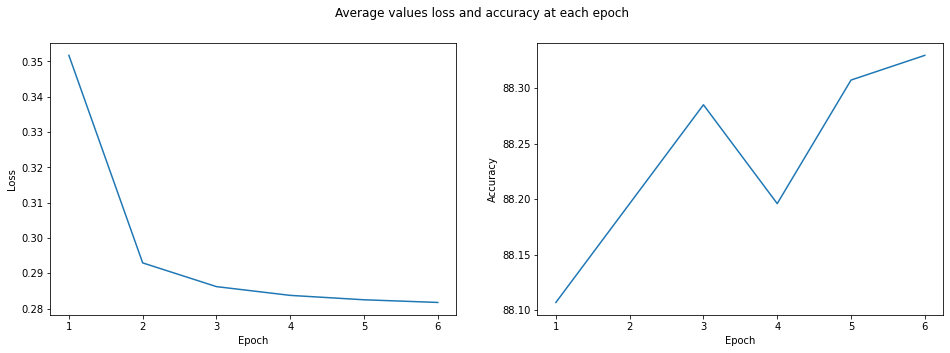

In [80]:
conv_net = ConvNet().to(device)
conv_net_accuracy = train_model(conv_net, epoch=6, lr=0.001)

In [81]:
network_results = network_results.append({'network': 'conv_net', 'accuracy': conv_net_accuracy}, ignore_index=True)

__Вывод__:  
Данная нейросеть показала результаты хуже предыдущей. В лучшем случае точность доходит до 90%, в основном колеблется в районе 85%. Возможно, эта сеть сложна для данной задачи, поэтому не показывает высоких результатов.

В следующих нейронках помимо полей `text` и `title` будет рассматриваться `subject`.

In [82]:
subject_columns = ['Government News', 'Middle-east', 'News', 'US_News', 'left-news',
       'politics', 'politicsNews', 'worldnews']

In [83]:
def collate_batch_complete(batch):
    processed_batch = []
    target = []
    text = []
    title = []
    subject  = []
    for record in batch:
        text.append(text_pipeline(record['text']))
        title.append(text_pipeline(record['title']))
        target.append(int(record['target']))
        subject.append([record[key] for key in subject_columns])
    result_dict = {
        'text': torch.tensor(text, dtype=torch.int64),
        'title': torch.tensor(title, dtype=torch.int64),
        'subject': torch.tensor(subject, dtype=torch.int64),
        'target': torch.tensor(target, dtype=torch.int64)
    }
    return result_dict

In [84]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_complete)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_complete)

- Нейросеть с одним линейным слоем

In [85]:
class LinearNetWithSubject(nn.Module):
    def __init__(self):
        super(LinearNetWithSubject, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.size = MAX_LEN * embed_dim
        self.fc = nn.Linear(self.size * 2 + len(subject_columns), 2)

    def forward(self, text, title, subject, **kwargs):
        text = self.embedding(text)
        title = self.embedding(title)
        with torch.no_grad():
            text = text.view(-1, self.size)
            title = title.view(-1, self.size)
            temp = torch.cat([text, title, subject], 1)
        return self.fc(temp)

Processing records:   0%|          | 0/25255 [00:00<?, ?it/s]

[1] loss: 0.02465826998277157
Accuracy of the network: 99.57683741648107
[2] loss: 0.004100803459081419
Accuracy of the network: 99.71046770601336
[3] loss: 0.0017632650267060323
Accuracy of the network: 99.71046770601336
[4] loss: 0.0011866206068928203
Accuracy of the network: 99.71046770601336
[5] loss: 0.0009441125298189924
Accuracy of the network: 99.71046770601336
Finished Training


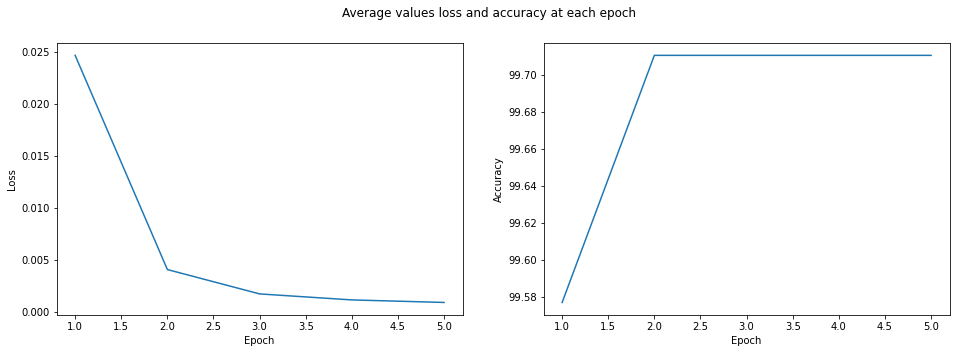

In [86]:
linear_net_with_subject = LinearNetWithSubject().to(device)
linear_net_with_subject_accuracy = train_model(linear_net_with_subject, epoch=5, lr=0.001)

In [87]:
network_results = network_results.append({'network': 'linear_net_with_subject', 'accuracy': linear_net_with_subject_accuracy}, ignore_index=True)

__Вывод__:  
Данная нейросеть показала довольно хороший результат, лучше предыдущих нейронок. Под конец обучения точность перестала расти, хотя значение ошибки падает.

- Нейросеть со свёрточными слоями

In [88]:
class ConvNetWithSubject(nn.Module):
    def __init__(self):
        super(ConvNetWithSubject, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.text_sequence = nn.Sequential(
            nn.Conv2d(1, 4, (7, embed_dim)),
            nn.ReLU()
        )
        self.title_sequence = nn.Sequential(
            nn.Conv2d(1, 4, (7, embed_dim)),
            nn.ReLU()
        )
        self.size = (MAX_LEN-6) * 4
        self.linear = nn.Linear(self.size * 2+len(subject_columns), 2)

    def forward(self, text, title, subject, **kwargs):
        text = self.embedding(text)
        title = self.embedding(title)
        
        text = torch.unsqueeze(text, 1)
        title = torch.unsqueeze(title, 1)

        text = self.text_sequence(text)
        title = self.text_sequence(title)
        
        with torch.no_grad():
            text = text.view(-1, self.size)
            title = title.view(-1, self.size)
            temp = torch.cat([text, title, subject], 1)
        return self.linear(temp)

Processing records:   0%|          | 0/20204 [00:00<?, ?it/s]

[1] loss: 0.1332315776039485
Accuracy of the network: 99.9554565701559
[2] loss: 0.03736273149748255
Accuracy of the network: 100.0
[3] loss: 0.02276727461427195
Accuracy of the network: 100.0
[4] loss: 0.01638430261247301
Accuracy of the network: 100.0
Finished Training


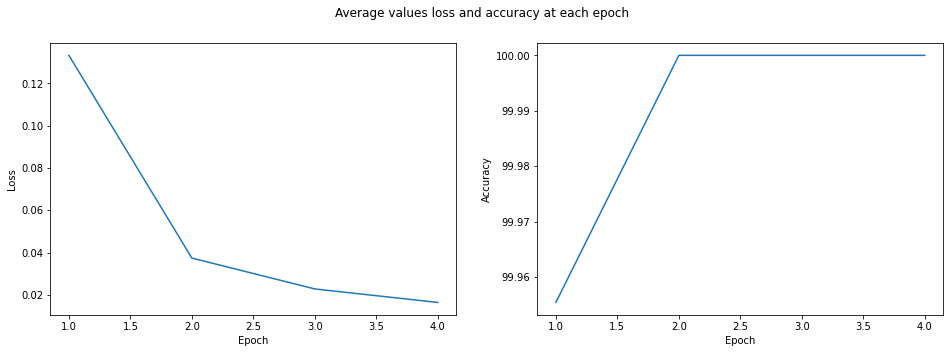

In [89]:
conv_net_wih_subject = ConvNetWithSubject().to(device)
conv_net_wih_subject_accuracy = train_model(conv_net_wih_subject, epoch=4, lr=0.00105)

In [90]:
network_results = network_results.append({'network': 'conv_net_wih_subject', 'accuracy': conv_net_wih_subject_accuracy}, ignore_index=True)

__Вывод__  
Самый лучший результат среди представленных здесь нейронок. Для обучения требуется небольшое кол-во эпох(в данном примере точность в 100% была достигнута на 3-ей эпохе).

- Результаты моделей

In [91]:
network_results.head()

,network,accuracy
0,linear_net,99.755011
1,conv_net,88.329621
2,linear_net_with_subject,99.710468
3,conv_net_wih_subject,100.000000


Добавление поля `subject` положительно сказалось на результатах.  
Лучшая нейросеть `conv_net_wih_subject` с точностью _100%_.